<a href="https://colab.research.google.com/github/kaicong12/CNN-/blob/main/TopicModelling_Shopee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gensim
!pip install pyLDAvis
!pip install spacy
!pip install wordcloud
!pip install nltk
!pip install scikit-learn
!pip install scipy

     |████████████████████████████████| 1.7MB 6.8MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=01ea9d5566ed4b5251a3551cbb27aa464d3e7d4a9c8952493b07ed3a1f426e79
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis


In [2]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [3]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import gensim
import numpy as np
import spacy
import math
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

import os, re, operator, warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [4]:
def clean(text):
    return str(''.join([i if ord(i) < 128 else ' ' for i in text]))

test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
lee_train_file = test_data_dir + os.sep + 'lee_background.cor'

In [5]:
def IDF(corpus, unique_words):
    idf_dict={}
    N=len(corpus)
    for i in unique_words:
        count=0
        for sen in corpus:
            if i in sen.split():
                count=count+1
            idf_dict[i]=(math.log((1+N)/(count+1)))+1
    return idf_dict

def fit(whole_data):
    unique_words = set()
    if isinstance(whole_data, (list,)):
        for x in whole_data:
            for y in x.split():
                if len(y)<2:
                    continue
                unique_words.add(y)
        unique_words = sorted(list(unique_words))
        vocab = {j:i for i,j in enumerate(unique_words)}
        Idf_values_of_all_unique_words=IDF(whole_data,unique_words)
    return vocab, Idf_values_of_all_unique_words

def transform(dataset,vocabulary,idf_values):
    vocab = {}
    sparse_matrix= csr_matrix( (len(dataset), len(vocabulary)), dtype=np.float64)
    for row  in range(0,len(dataset)):
        number_of_words_in_sentence=Counter(dataset[row].split())
        for word in dataset[row].split():
            if word in  list(vocabulary.keys()):
                tf_idf_value=(number_of_words_in_sentence[word]/len(dataset[row].split()))*(idf_values[word])
                sparse_matrix[row,vocabulary[word]]=tf_idf_value
                vocab[word] = tf_idf_value
    return vocab

In [9]:
text = open(lee_train_file).read()
nlp = spacy.load('en_core_web_sm')
stop_words = stopwords.words('english') #imported from nltk.corpus

In [10]:
for stopword in stop_words:
  lexeme = nlp.vocab[stopword]
  lexeme.is_stop = True

In [11]:
doc = nlp(clean(text)) #convert the text to unicode so that computer can read it

In [59]:
#clean the document and only get relevant words
texts, article = [], []
for w in doc:
  if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num:
    article.append(w.lemma_) # we only want the root words
  if w.text == '\n':
    texts.append(article)
    article = [] 

In [19]:
texts[:5]

[['hundred',
  'people',
  'force',
  'vacate',
  'home',
  'Southern',
  'Highlands',
  'New',
  'South',
  'Wales',
  'strong',
  'wind',
  'today',
  'push',
  'huge',
  'bushfire',
  'town',
  'Hill',
  'new',
  'blaze',
  'near',
  'Goulburn',
  'south',
  'west',
  'Sydney',
  'force',
  'closure',
  'Hume',
  'Highway',
  '4:00pm',
  'aedt',
  'marked',
  'deterioration',
  'weather',
  'storm',
  'cell',
  'move',
  'east',
  'Blue',
  'Mountains',
  'force',
  'authority',
  'decision',
  'evacuate',
  'people',
  'home',
  'outlying',
  'street',
  'Hill',
  'New',
  'South',
  'Wales',
  'southern',
  'highland',
  'estimated',
  'resident',
  'leave',
  'home',
  'nearby',
  'Mittagong',
  'New',
  'South',
  'Wales',
  'Rural',
  'Fire',
  'Service',
  'say',
  'weather',
  'condition',
  'cause',
  'fire',
  'burn',
  'finger',
  'formation',
  'ease',
  'fire',
  'unit',
  'Hill',
  'optimistic',
  'defend',
  'property',
  'blaze',
  'burn',
  'New',
  'Year',
  'Eve',


In [23]:
#join all the words in texts together

transformed_texts = [' '.join(i) for i in texts] #leave a space so that there is a space in between every words
transformed_texts_1 = [i.lower for i in transformed_texts]

In [24]:
transformed_texts

['hundred people force vacate home Southern Highlands New South Wales strong wind today push huge bushfire town Hill new blaze near Goulburn south west Sydney force closure Hume Highway 4:00pm aedt marked deterioration weather storm cell move east Blue Mountains force authority decision evacuate people home outlying street Hill New South Wales southern highland estimated resident leave home nearby Mittagong New South Wales Rural Fire Service say weather condition cause fire burn finger formation ease fire unit Hill optimistic defend property blaze burn New Year Eve New South Wales fire crew call new fire Gunning south Goulburn detail available stage fire authority say close Hume Highway direction new fire Sydney west longer threaten property Cranebrook area rain fall part Illawarra Sydney Hunter Valley north coast Bureau Meteorology Claire Richards say rain little ease fire burn state fall isolate area generally fall millimetre say place significant millimetre relief far rain concern f

In [52]:
# look up on regex for word digits word
transformed_texts_2 = [re.match(r'\w*\d\w*', i ).strip() for i in transformed_texts_1]

TypeError: ignored

In [37]:
Vocabulary, idf_of_vocabulary = fit(transformed_texts_2)

#vocabulary will contain each word and the placements of each word

In [38]:
sorted_idf = dict(sorted(idf_of_vocabulary.items(), key=operator.itemgetter(1), reverse = True))

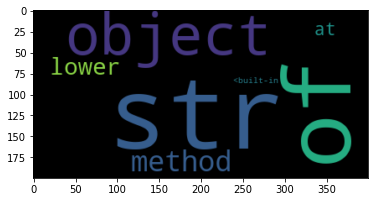

In [40]:
#generate a word cloud based on frequency of the word 
wordcloud = WordCloud().generate_from_frequencies(Vocabulary)

#take out some of the words so that it is not so clustered
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [44]:
# if we use idf_of_vocabulary, we can plot the rare words
# or we can also extend our stopwords

stop_words.extend(['aamer'])
stopwords_dict = Counter(stop_words)
transformed_texts_3 = [' '.join([word for word in i.split() if word not in stopwords_dict]) for i in transformed_texts_2]

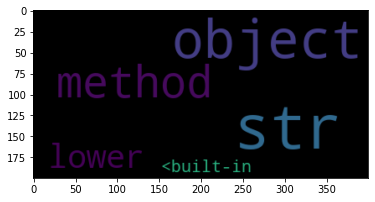

In [46]:
Vocabulary, idf_of_vocabulary = fit(transformed_texts_3) #this would remove aamer from the word cloud
wordcloud = WordCloud().generate_from_frequencies(Vocabulary)

#take out some of the words so that it is not so clustered
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [47]:
final_output = transform(transformed_texts_3, Vocabulary, idf_of_vocabulary)

In [48]:
final_output

{'<built-in': 0.16666666666666666,
 'lower': 0.16666666666666666,
 'method': 0.16666666666666666,
 'object': 0.16666666666666666,
 'str': 0.16666666666666666}

In [50]:
#tfidf implementation using sklearn 

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,norm='5',encoding='latin-1',ngram_range=(1,1),stop_words=stop_words)
features = tfidf.fit_transform(transformed_text_3)

d = tfidf.vocabulary_

ValueError: ignored

In [51]:
#sentiment analysis using vader 

sid = SentimentIntensityAnalyzer()
for i  in range(len(transformed_texts_3)):
  print(transformed_texts_3[i] + ':')
  scores = sid.polarity_scores(transformed_texts_3[i])
  print(scores)


<built-in method lower str object >:
{'neg': 0.355, 'neu': 0.645, 'pos': 0.0, 'compound': -0.296}
<built-in method lower str object >:
{'neg': 0.355, 'neu': 0.645, 'pos': 0.0, 'compound': -0.296}
<built-in method lower str object >:
{'neg': 0.355, 'neu': 0.645, 'pos': 0.0, 'compound': -0.296}
<built-in method lower str object >:
{'neg': 0.355, 'neu': 0.645, 'pos': 0.0, 'compound': -0.296}
<built-in method lower str object >:
{'neg': 0.355, 'neu': 0.645, 'pos': 0.0, 'compound': -0.296}
<built-in method lower str object >:
{'neg': 0.355, 'neu': 0.645, 'pos': 0.0, 'compound': -0.296}
<built-in method lower str object >:
{'neg': 0.355, 'neu': 0.645, 'pos': 0.0, 'compound': -0.296}
<built-in method lower str object >:
{'neg': 0.355, 'neu': 0.645, 'pos': 0.0, 'compound': -0.296}
<built-in method lower str object >:
{'neg': 0.355, 'neu': 0.645, 'pos': 0.0, 'compound': -0.296}
<built-in method lower str object >:
{'neg': 0.355, 'neu': 0.645, 'pos': 0.0, 'compound': -0.296}
<built-in method low

In [61]:
#TOPIC MODELLING = find the summary on what the article is about
#HDP it will find the optimal number of topics for you 
#for LDA, you have to specify the number of topics you want to summarize
texts

[['hundred',
  'people',
  'force',
  'vacate',
  'home',
  'Southern',
  'Highlands',
  'New_South',
  'Wales',
  'strong',
  'wind',
  'today',
  'push',
  'huge',
  'bushfire',
  'town',
  'Hill',
  'new',
  'blaze',
  'near',
  'Goulburn',
  'south_west',
  'Sydney',
  'force',
  'closure',
  'Hume',
  'Highway',
  '4:00pm',
  'aedt',
  'marked',
  'deterioration',
  'weather',
  'storm',
  'cell',
  'move',
  'east',
  'Blue_Mountains',
  'force',
  'authority',
  'decision',
  'evacuate',
  'people',
  'home',
  'outlying',
  'street',
  'Hill',
  'New_South',
  'Wales',
  'southern',
  'highland',
  'estimated',
  'resident',
  'leave',
  'home',
  'nearby',
  'Mittagong',
  'New_South',
  'Wales',
  'Rural_Fire',
  'Service',
  'say',
  'weather_condition',
  'cause',
  'fire_burn',
  'finger',
  'formation',
  'ease',
  'fire',
  'unit',
  'Hill',
  'optimistic',
  'defend',
  'property',
  'blaze',
  'burn',
  'New',
  'Year',
  'Eve',
  'New_South',
  'Wales',
  'fire',
  'c

In [60]:
bigram = gensim.models.Phrases(texts)
texts = [bigram[line] for line in texts]

In [62]:
texts #combine all the text that gensim recogizes together

[['hundred',
  'people',
  'force',
  'vacate',
  'home',
  'Southern',
  'Highlands',
  'New_South',
  'Wales',
  'strong',
  'wind',
  'today',
  'push',
  'huge',
  'bushfire',
  'town',
  'Hill',
  'new',
  'blaze',
  'near',
  'Goulburn',
  'south_west',
  'Sydney',
  'force',
  'closure',
  'Hume',
  'Highway',
  '4:00pm',
  'aedt',
  'marked',
  'deterioration',
  'weather',
  'storm',
  'cell',
  'move',
  'east',
  'Blue_Mountains',
  'force',
  'authority',
  'decision',
  'evacuate',
  'people',
  'home',
  'outlying',
  'street',
  'Hill',
  'New_South',
  'Wales',
  'southern',
  'highland',
  'estimated',
  'resident',
  'leave',
  'home',
  'nearby',
  'Mittagong',
  'New_South',
  'Wales',
  'Rural_Fire',
  'Service',
  'say',
  'weather_condition',
  'cause',
  'fire_burn',
  'finger',
  'formation',
  'ease',
  'fire',
  'unit',
  'Hill',
  'optimistic',
  'defend',
  'property',
  'blaze',
  'burn',
  'New',
  'Year',
  'Eve',
  'New_South',
  'Wales',
  'fire',
  'c

In [63]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [64]:
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 2),
  (7, 1),
  (8, 1),
  (9, 2),
  (10, 3),
  (11, 2),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 4),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 3),
  (23, 1),
  (24, 4),
  (25, 1),
  (26, 1),
  (27, 2),
  (28, 1),
  (29, 2),
  (30, 1),
  (31, 2),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 3),
  (54, 1),
  (55, 1),
  (56, 5),
  (57, 2),
  (58, 1),
  (59, 3),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 3),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 2),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 3),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 2),
  (83, 1),
  (84, 1),
  (85, 2),
  (86, 1),
  (87, 3),
  (88, 1),
  (89, 1),
  (90, 4),
  (91, 1)

In [65]:
# pre-defined number of topics
lsimodel = LsiModel(corpus = corpus, num_topics=10, id2word=dictionary)
lsimodel.show_topics()  #this shows what each of the topic is roughly about

[(0,
  '0.789*"say" + 0.142*"Mr" + 0.097*"israeli" + 0.095*"force" + 0.094*"people" + 0.083*"Australia" + 0.082*"kill" + 0.080*"attack" + 0.079*"official" + 0.078*"palestinian"'),
 (1,
  '-0.394*"israeli" + -0.336*"palestinian" + -0.285*"Mr_Arafat" + -0.192*"Israel" + -0.178*"official" + 0.165*"say" + -0.165*"Hamas" + -0.155*"kill" + -0.151*"West_Bank" + -0.138*"attack"'),
 (2,
  '0.312*"Afghanistan" + 0.294*"force" + 0.219*"Al_Qaeda" + 0.196*"bin_Laden" + 0.161*"fighter" + 0.154*"Taliban" + 0.154*"Tora_Bora" + 0.146*"Pakistan" + 0.119*"afghan" + -0.113*"fire"'),
 (3,
  '-0.404*"fire" + -0.293*"area" + -0.247*"Sydney" + -0.196*"firefighter" + -0.178*"north" + -0.170*"wind" + -0.168*"New_South" + -0.168*"Wales" + -0.142*"south" + -0.129*"line"'),
 (4,
  '0.249*"Mr" + -0.234*"test" + -0.227*"Australia" + -0.216*"day" + -0.197*"match" + -0.183*"South_Africa" + -0.177*"wicket" + -0.159*"good" + -0.157*"play" + -0.132*"catch"'),
 (5,
  '0.341*"Mr" + -0.315*"say" + 0.220*"force" + 0.181*"com

In [66]:
#HDP model - undefined number of topics
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
hdpmodel.show_topics()
# identified 20 topics

[(0,
  '0.010*say + 0.004*storm + 0.003*Taliban + 0.003*airport + 0.003*night + 0.003*area + 0.003*work + 0.002*tree + 0.002*injure + 0.002*opposition + 0.002*damage + 0.002*kill + 0.002*Sydney + 0.002*city + 0.002*SES + 0.002*Kandahar + 0.002*hit + 0.002*leave + 0.002*force + 0.002*place'),
 (1,
  '0.004*israeli + 0.003*say + 0.002*Mr_Arafat + 0.002*official + 0.002*cent + 0.002*job + 0.002*Mr_Sharon + 0.002*palestinian + 0.002*crowd + 0.002*target + 0.002*ruthless + 0.002*group + 0.002*drop + 0.002*start + 0.001*attack + 0.001*West_Bank + 0.001*military + 0.001*force + 0.001*choose + 0.001*Olivier'),
 (2,
  '0.005*say + 0.005*company + 0.002*collapse + 0.002*entitlement + 0.002*Justice + 0.002*Austar + 0.002*staff + 0.002*commission + 0.002*today + 0.002*morning + 0.002*Owen + 0.002*Mr + 0.002*HIH + 0.002*$ + 0.002*hearing + 0.001*royal_commission + 0.001*administrator + 0.001*leak + 0.001*cent + 0.001*share'),
 (3,
  '0.006*say + 0.003*group + 0.003*palestinian + 0.003*kill + 0.002*

In [67]:
ldamodel = LdaModel(corpus = corpus, num_topics=10, id2word=dictionary)
ldamodel.show_topics()

[(0,
  '0.021*"say" + 0.007*"Mr" + 0.007*"Australia" + 0.005*"people" + 0.005*"israeli" + 0.005*"force" + 0.004*"palestinian" + 0.004*"Sydney" + 0.004*"fire" + 0.003*"Mr_Arafat"'),
 (1,
  '0.037*"say" + 0.004*"Mr" + 0.004*"israeli" + 0.004*"day" + 0.004*"fire" + 0.004*"force" + 0.004*"today" + 0.004*"believe" + 0.003*"tell" + 0.003*"area"'),
 (2,
  '0.029*"say" + 0.005*"Mr" + 0.004*"new" + 0.004*"force" + 0.004*"israeli" + 0.004*"year" + 0.004*"United_States" + 0.003*"attack" + 0.003*"people" + 0.003*"Australia"'),
 (3,
  '0.016*"say" + 0.006*"Mr" + 0.005*"year" + 0.004*"force" + 0.004*"new" + 0.004*"group" + 0.004*"agreement" + 0.003*"cent" + 0.003*"Qantas" + 0.003*"Taliban"'),
 (4,
  '0.022*"say" + 0.006*"Mr" + 0.004*"Afghanistan" + 0.004*"Government" + 0.004*"force" + 0.004*"report" + 0.004*"day" + 0.003*"claim" + 0.003*"Australia" + 0.003*"company"'),
 (5,
  '0.032*"say" + 0.005*"Mr" + 0.004*"company" + 0.003*"union" + 0.003*"australian" + 0.003*"Governor_General" + 0.003*"fire" + 

In [68]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel,corpus,dictionary)
#explore whether are the topics overlapping

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.004690 -0.018399       1        1  21.199804
2     -0.001998  0.000642       2        1  18.962973
0      0.019525 -0.054086       3        1  13.208332
7     -0.022485  0.009506       4        1  11.388053
5     -0.050404  0.009304       5        1   7.807160
9     -0.028195  0.031798       6        1   7.274099
8      0.043211  0.048972       7        1   6.623852
3      0.013525 -0.031052       8        1   6.458977
4     -0.032366 -0.009740       9        1   5.033401
6      0.054498  0.013055      10        1   2.043349, topic_info=             Term        Freq       Total Category  logprob  loglift
90            say  813.000000  813.000000  Default  30.0000  30.0000
848       israeli   86.000000   86.000000  Default  29.0000  29.0000
2367      company   57.000000   57.000000  Default  28.0000  28.0000
855   palestinian   67.000000   67.000000  Default  27.0000  27.0000
1005           Mr  158.000000  158.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
136          come    1.163889   63.727466  Topic10  -6.2632  -0.1123
129        attack    1.174617   79.510084  Topic10  -6.2540  -0.3244
312     Australia    1.145401  116.285327  Topic10  -6.2792  -0.7297
59          force    1.096713   94.877237  Topic10  -6.3226  -0.5697
17      New_South    1.079001   34.541059  Topic10  -6.3389   0.4245

[798 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
646       1  0.211687           
646       2  0.190518           
646       3  0.105844           
646       4  0.148181           
646       5  0.084675           
...     ...       ...        ...
180       6  0.094759  yesterday
180       7  0.047379  yesterday
180       8  0.047379  yesterday
180       9  0.047379  yesterday
180      10  0.023690  yesterday

[2208 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 8, 6, 10, 9, 4, 5, 7])

In [69]:
#compare the performance of the three models
lsitopics = [[word for word,prob in topic] for topicid, topic in lsimodel.show_topics(formatted = False)]
hdptopics = [[word for word,prob in topic] for topicid, topic in hdpmodel.show_topics(formatted = False)]
ldatopics = [[word for word,prob in topic] for topicid, topic in ldamodel.show_topics(formatted = False)]

In [70]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()
lda_coherence = CoherenceModel(topics=ldatopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()
    

In [73]:
def evaluate_bar_graph(coherences, indices):
  assert len(coherences) == len(indices)
  n = len(coherences)
  x = np.arange(n)
  plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
  plt.xlabel("Models")
  plt.ylabel("Coherence Value")
  plt.show()

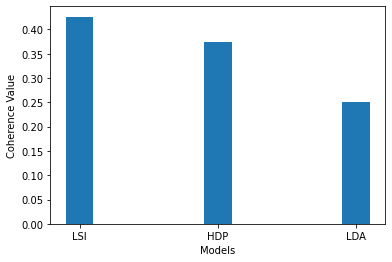

In [74]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence], ["LSI", "HDP", "LDA"])
#LSI is the best performing model since it has the highest coherence value